# Deutsch-Jozsa algorithm

In [126]:
%%js
//Setup to prevent auto-scroll output 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
element.text('Autoscrolling output disabled!!')
// See for more: 
// https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling

<IPython.core.display.Javascript object>

In [127]:
import numpy as np
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline

### <font color='indigo'>-- Create the oracle for $n+1$ qubits</font>

Like in the single qubit case, the $n$-qubit oracle works update the input qubits via the ancilla qubit (exploiting phase kickback and superposition). Here the oracle operator $\hat{O}_f$ is  generalized to a $n$-dimensional vector ${\bf x}$ in place of a single dimensional scalar $x$: 
 $\hat{O}_f  |y,{\bf x}\rangle = |y \oplus f({\bf x}), {\bf x}\rangle$. 

The construction of the oracle (selection of gates) follows the same table as the singel qubit Deutsch algorith. Only update is that each input qubit in $|{\bf x}\rangle = | x_1 x_2 \cdots x_n\rangle$ becomes the control qubit and the last ancilliary qubit ($|y\rangle$) becomes the target qubit when a $CX$ gate is applicable. Thus here eventually we apply multiqubit $CX$ gate or $MCX$ gate which can be thought as a higher dimensional Toffoli (CC...CNOT) gate.   

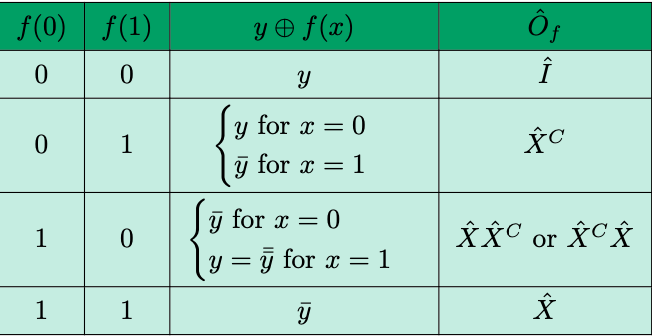

In [128]:
# Create the oracle implementing the unknown function
def make_multiqubit_oracle(n, function_values):
    
    oracle = QuantumCircuit(n + 1)
    
    ''' Deutsch algo code had (n=1) --v     
    if  f[0]:  # if f(0) = 1 
        oracle.cx(0, 1) 
        oracle.x(1)   # then O_f = X_c X
    if  f[1]:  # if f(1) = 1 
        oracle.cx(0, 1) # then O_f = X_c if f[0] = 0
                        # then O_f = X = X_c X X_c if f[0] = 1
                        # above statement takes care of both situations
                
    '''            
    for x in range(2**n):
        binary_x = format(x, f'0{n}b')  # Convert x to n-bit binary string
        if function_values[binary_x] == 1:
            for i, bit in enumerate(binary_x):
                if bit == '0':
                    oracle.x(i)
            oracle.mcx(list(range(n)), n)  # Multi-controlled X (Flips last qubit)
            for i, bit in enumerate(binary_x):
                if bit == '0':
                    oracle.x(i)            
    return oracle

### <font color='indigo'>-- Create Deutsch-Jozsa circuit</font>


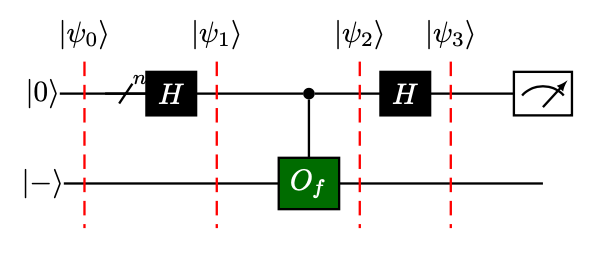

The above circuit looks similar to Deutsch circuit. However, note the '${/}^n$'  notation on the input circuit, which signifies $n$ copies of the same qubit. So the initial input qubit state is the multiqubit state $|0\rangle^{\otimes n}\rangle$. 


<!--<div> <img src="attachment:image.png" alt="Deutsch circuit" style="width: 600px;"/></div>--> 


In [129]:
# Create the Deutsch circuit that uses the oracle
def make_DJ_circuit(n, function_values):
    
    """ Older code (Deutsch circuit) ----v
    Creates the Deutsch algorithm circuit.

    Args:
        f(list): The unknown function [f(0), f(1)].

    Returns:
        QuantumCircuit: The Deutsch algorithm circuit.
    
    qc = QuantumCircuit(2, 1)

    # Initialize qubits
    qc.x(1)  # Set the second qubit to | 1 >
    qc.h(0)  # Creates state | + >
    qc.h(1) # Creates state | - >

    # Query oracle
    oracle = make_oracle(f)
    qc.compose(oracle, inplace=True)

    # Apply Hadamard gate to the first qubit
    qc.h(0)

    # Measure the first qubit
    qc.measure(0, 0)
    display(qc.draw('mpl'))
    return qc
    """

    """
    Constructs the Deutsch-Jozsa algorithm circuit.

    Args:
        n (int): Number of input qubits.
        function_values (dict): Function mapping input binary strings to {0,1}.

    Returns:
        QuantumCircuit: The Deutsch-Jozsa algorithm circuit.
    """
    qc = QuantumCircuit(n + 1, n)

    # Initialize last qubit to |1> and apply Hadamard gates
    qc.x(n)
    qc.h(range(n + 1))

    # Apply the oracle
    oracle = make_multiqubit_oracle(n, function_values)
    qc.compose(oracle, inplace=True)

    # Apply Hadamard again to first n qubits
    qc.h(range(n))

    # Measure the first n qubits
    qc.measure(range(n), range(n))
    display(qc.draw(output='mpl',scale=0.8))
    return qc

### <font color='indigo'>-- Implement Deutsch circuit with the oracle and simulate</font>

Function values: {'0000': 1, '0001': 0, '0010': 1, '0011': 0, '0100': 1, '0101': 0, '0110': 1, '0111': 1, '1000': 1, '1001': 0, '1010': 1, '1011': 0, '1100': 1, '1101': 0, '1110': 0, '1111': 0}
Number of 0s: 8, Number of 1s: 8


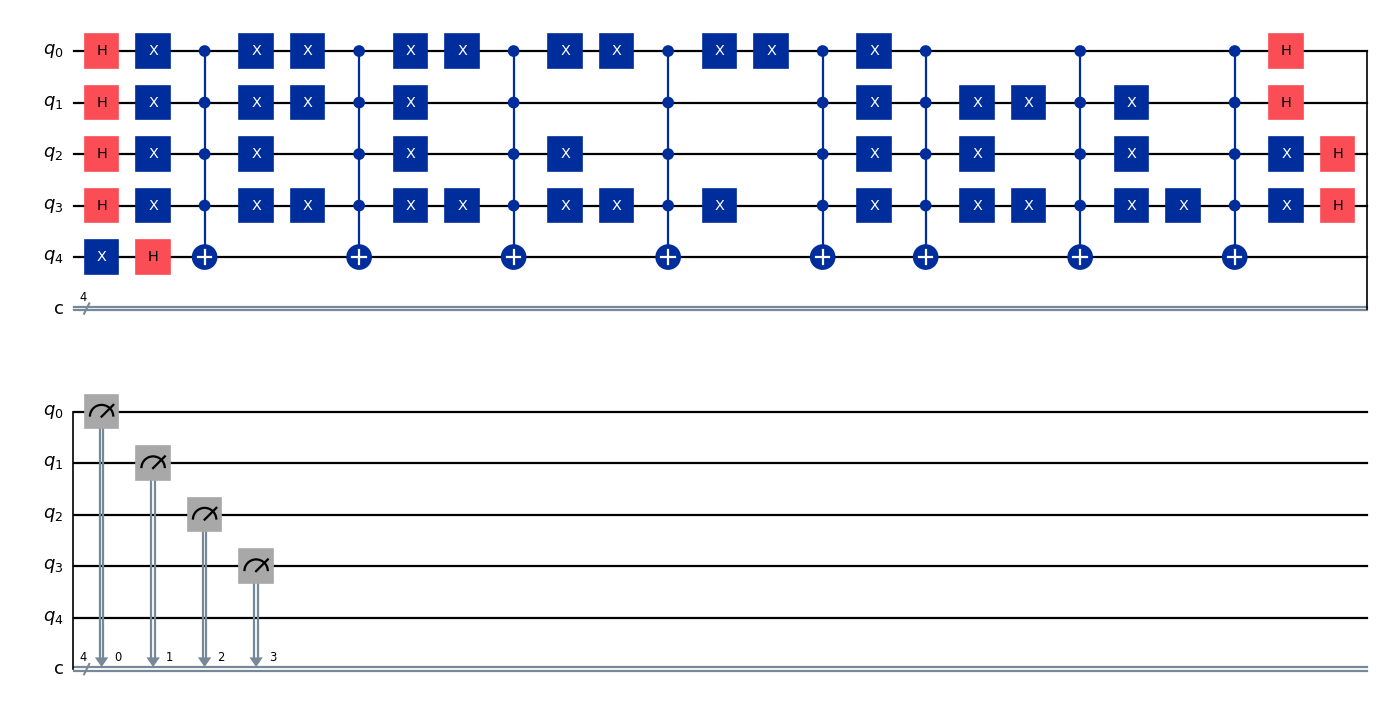

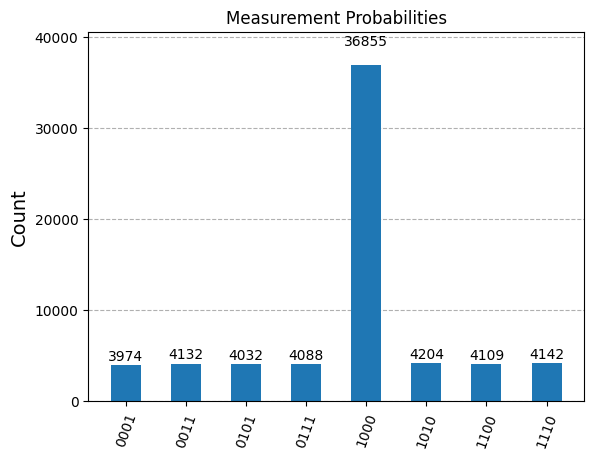

Function values: {'0000': 1, '0001': 0, '0010': 1, '0011': 0, '0100': 1, '0101': 0, '0110': 1, '0111': 1, '1000': 1, '1001': 0, '1010': 1, '1011': 0, '1100': 1, '1101': 0, '1110': 0, '1111': 0}
Measured probabilities: {'0001': 3974, '0101': 4032, '0011': 4132, '0111': 4088, '1100': 4109, '1000': 36855, '1110': 4142, '1010': 4204}
Probability of |000...0>: 0.0000
Determined function nature: BALANCED


In [136]:
# Run Deutsch-Jozsa algorithm and analyze results
def main_run_DJ(n, function_values, shots=65536):    
    """
    Runs the Deutsch-Jozsa algorithm and determines whether the function is constant or balanced.

    Args:
        n (int): Number of input qubits.
        function_values (dict): Function values mapping binary strings to {0,1}.
        shots (int): Number of measurement shots.

    Returns:
        str: "constant" or "balanced"
    """
    simulator = AerSimulator()

    # Create the Deutsch-Jozsa circuit
    dj_circuit = make_DJ_circuit(n, function_values)
    
    # Transpile and execute
    transpiled_circuit = transpile(dj_circuit, simulator)
    result = simulator.run(transpiled_circuit, shots=shots).result()
    
    # Extract measurement results
    counts = result.get_counts()
    
    # Convert measurement results to probabilities
    total_shots = sum(counts.values())
    prob_0000 = counts.get("0" * n, 0) / total_shots  # Probability of measuring |000...0>
    
    # Plot histogram
    #plt.figure(figsize=(8, 6))
    display(plot_histogram(counts, title="Measurement Probabilities"))
    
    # Print function values
    print(f"Function values: {function_values}")
    print(f"Measured probabilities: {counts}")
    print(f"Probability of |000...0>: {prob_0000:.4f}")

    # Determine if function is constant or balanced
    return "CONSTANT" if prob_0000 > 0.9 else "BALANCED"


''' Older (Deutsch algo)      ----------------v
# Main function to simulate Deutsch's algorithm
def main():
    
    # Generate a random unknown function
    f_test = [random.randint(0, 1) for _ in range(2)]
    #f_test = [0, 0] # f(0)=0, f(1)=0 , i.e. CONSTANT f
    #f_test = [1,1] #  f(0)=1, f(1)=0 , i.e. BALANCED f
    print('Unknown function, f(x) =',f_test,' for x in {0,1}.')
    
    
    # Create the Deutsch algorithm circuit
    deutsch_circuit = make_deutsch_circuit(f_test)
    
    # Simulate the circuit
    nshot = 10
    simulator = AerSimulator()
    transpiled_circuit = transpile(deutsch_circuit, simulator)
    result = simulator.run(transpiled_circuit, shots=nshot).result()
    
    # Collect counts
    counts = result.get_counts()
    print('Counts =',counts,'; No of shots =',nshot)
    
    # Visualize the results
    print("Measurement results:", counts)
    #plt.figure(figsize=(4, 3))
    hist = plot_histogram(counts)
    display(hist)
    
    #result_key = max(counts, key=counts.get)
    result_key = list(counts.keys())[0] 
    print('Result_key =',result_key)
    # Print results
    #print(f"Unknown function: f(x) = [{', '.join(map(str, f_test))}]")
    print("Circuit:")
    print(deutsch_circuit)
    print(f"f(0)⊕f(1) = {result_key}")
    
    if int(result_key) == 0:   
     print('The function is CONSTANT')
    else:
     print('The function is BALANCED')

'''     

# Execute the main function
# Test case: n=4 
n = 4
choice = 3
if choice == 0:
  function_values = {format(i, f'0{n}b'): 1 for i in range(2**n)}  # All 1's (Constant)
elif choice == 1:
  function_values = {format(i, f'0{n}b'): 0 for i in range(2**n)}  # All 0's (Constant)
elif choice == 2:  # 2^{n-1} 0's and 2^{n-1} 1's   
  function_values = {format(i, f'0{n}b'): int(i >= 2**(n-1)) for i in range(2**n)}
else:
    if random.choice([False, True]):  
        # Balanced function
        function_values = {
        format(i, f'0{n}b'): v
        for i, v in enumerate(random.sample([0] * (2**(n-1)) + [1] * (2**(n-1)), 2**n))
        }
    else:
        # Constant function (all 0s or all 1s)
        constant_value = random.choice([0, 1])  # Either all 0s or all 1s
        function_values = {format(i, f'0{n}b'): constant_value for i in range(2**n)}

# Generate randomly constant or balanced function values
#function_values = {format(i, f'0{n}b'): random.choice([0, 1]) if random.choice([True, False]) else int(i in random.sample(range(2**n), 2**(n-1))) for i in range(2**n)}

count_0 = sum(1 for v in function_values.values() if v == 0)
count_1 = sum(1 for v in function_values.values() if v == 1)

# Print the function and counts
print("Function values:", function_values)
print(f"Number of 0s: {count_0}, Number of 1s: {count_1}")

# Run and print result
function_type = main_run_DJ(n, function_values)
print(f"Determined function nature: {function_type}")

In [131]:
# Test:
function_values = {format(i, f'0{n}b'): random.choice([0, 1]) if random.choice([True, False]) else int(i in random.sample(range(2**n), 2**(n-1))) for i in range(2**n)}
print(function_values)

{'0000': 0, '0001': 0, '0010': 1, '0011': 1, '0100': 0, '0101': 0, '0110': 0, '0111': 1, '1000': 1, '1001': 0, '1010': 0, '1011': 1, '1100': 0, '1101': 0, '1110': 0, '1111': 1}


#### Simulation on real quantum hardware: 
Check: 
1) https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/deutsch_jozsa.ipynb 

2) https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/deutsch-jozsa.ipynb